In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sb
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp

from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from mpl_toolkits.mplot3d import axes3d
from pylab import rcParams
import os
from tqdm import tqdm
#%matplotlib notebook

In [8]:
clases=['muon','electron','piminus']

In [9]:
def compute_profile(x, y, nbin=(100, 100)):
    # use of the 2d hist by numpy to avoid plotting
    h, xe, ye = np.histogram2d(x, y, nbin)

    # bin width
    xbinw = xe[1] - xe[0]

    # getting the mean and RMS values of each vertical slice of the 2D distribution
    # also the x valuse should be recomputed because of the possibility of empty slices
    x_array = []
    x_slice_mean = []
    x_slice_rms = []
    for i in range(xe.size - 1):
        yvals = y[(x > xe[i]) & (x <= xe[i + 1])]
        if yvals.size > 0:  # do not fill the quanties for empty slices
            x_array.append(xe[i] + xbinw / 2)
            x_slice_mean.append(yvals.mean())
            x_slice_rms.append(yvals.std())
    x_array = np.array(x_array)
    x_slice_mean = np.array(x_slice_mean)
    x_slice_rms = np.array(x_slice_rms)

    return x_array, x_slice_mean, x_slice_rms

In [10]:
files = [os.path.join('data/dataset/',f) for f in os.listdir('data/dataset/')]
dfdata=pd.DataFrame()
for f in tqdm(files):

    h5 = h5py.File(f, 'r')

    keys = ['E', 'azimuth', 'cycle', 'eff', 'enter.x', 'enter.y', 'enter.z', 'evt', 'exit.x', 'exit.y', 'exit.z',
            'nhitslc', 'nhittot', 'p.E', 'p.px', 'p.py', 'p.pz', 'pdg', 'penter.E', 'penter.px', 'penter.py', 'penter.pz',
            'rec.mc.cosmic_idx', 'run', 'stop.x', 'stop.y', 'stop.z', 'subevt', 'subrun', 'time', 'visE', 'visEinslc',
            'vtx.x', 'vtx.y', 'vtx.z', 'zenith']
    data = {}
    for k in keys:
        data[k] = np.array(h5[k])

    data = pd.DataFrame(data)
    #data['cvnmap'] = np.array(f['cvnmap'])
    data['euclidean'] = (((data['vtx.x'] - data['stop.x']) ** 2) +
                         (data['vtx.y'] - data['stop.y']) ** 2 +
                         (data['vtx.z'] - data['stop.z']) ** 2) ** .5


    def set_values(row, value):
        return value[row]


    map_dictionary = {11: 1, 13: 0, -211: 2}

    data['label'] = data['pdg'].apply(set_values, args=(map_dictionary,))

    h5.close()
    dfdata=pd.concat([dfdata, data],
                  ignore_index = True)
dfdata

100%|██████████| 2989/2989 [01:27<00:00, 33.97it/s]


,E,azimuth,cycle,eff,enter.x,enter.y,enter.z,evt,exit.x,exit.y,...,subrun,time,visE,visEinslc,vtx.x,vtx.y,vtx.z,zenith,euclidean,label
0,1.706486,2.590457,0,1.000000,57.197571,-8.897424,53.937347,961,-4.573000,9.138374,...,19,14005.0,0.945229,0.945229,57.197571,-8.897424,53.937347,-0.204848,80.995926,1
1,0.984304,1.921182,0,0.999742,-122.303650,109.621239,161.948975,133,-129.019821,39.828960,...,19,14005.0,0.559785,0.559641,-122.303650,109.621239,161.948975,0.966977,72.341995,1
2,4.875452,-1.410617,0,0.991403,-126.638290,-145.367905,639.660034,913,-116.645882,-164.115311,...,19,14005.0,1.128640,1.118937,-126.638290,-145.367905,639.660034,0.344875,55.028706,1
3,0.619690,1.015395,0,1.000000,-147.323227,-85.382751,320.650421,724,-142.068787,-142.595001,...,19,14005.0,0.174495,0.174495,-147.323227,-85.382751,320.650421,0.969673,59.334763,1
4,1.892111,-3.096459,0,0.998630,-98.762085,-71.649002,470.146423,233,-147.510574,-7.106601,...,19,14005.0,0.932748,0.931470,-98.762085,-71.649002,470.146423,-0.789564,80.923500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149445,0.378008,1.590094,0,0.853130,-2.028179,23.365307,474.820007,1531,-10.871884,-21.376598,...,0,14005.0,0.185925,0.158618,-2.028179,23.365307,474.820007,0.382194,116.472855,0
149446,1.592348,-1.683670,0,0.971325,-118.720650,134.297974,950.566956,1987,-166.421448,-6.745108,...,0,14005.0,1.013507,0.984444,-118.720650,134.297974,950.566956,0.185656,738.165039,0
149447,0.187975,1.086285,0,0.909831,-8.794808,-0.185132,618.794006,1001,1.550654,-11.576729,...,0,14005.0,0.060334,0.054894,-8.794808,-0.185132,618.794006,0.414365,24.738651,0
149448,0.360791,-1.085491,0,1.000000,-169.231598,51.664352,430.558319,363,-122.274002,1.842017,...,0,14005.0,0.156087,0.156087,-169.231598,51.664352,430.558319,0.459921,112.796448,0


In [11]:
dfdata

,E,azimuth,cycle,eff,enter.x,enter.y,enter.z,evt,exit.x,exit.y,...,subrun,time,visE,visEinslc,vtx.x,vtx.y,vtx.z,zenith,euclidean,label
0,1.706486,2.590457,0,1.000000,57.197571,-8.897424,53.937347,961,-4.573000,9.138374,...,19,14005.0,0.945229,0.945229,57.197571,-8.897424,53.937347,-0.204848,80.995926,1
1,0.984304,1.921182,0,0.999742,-122.303650,109.621239,161.948975,133,-129.019821,39.828960,...,19,14005.0,0.559785,0.559641,-122.303650,109.621239,161.948975,0.966977,72.341995,1
2,4.875452,-1.410617,0,0.991403,-126.638290,-145.367905,639.660034,913,-116.645882,-164.115311,...,19,14005.0,1.128640,1.118937,-126.638290,-145.367905,639.660034,0.344875,55.028706,1
3,0.619690,1.015395,0,1.000000,-147.323227,-85.382751,320.650421,724,-142.068787,-142.595001,...,19,14005.0,0.174495,0.174495,-147.323227,-85.382751,320.650421,0.969673,59.334763,1
4,1.892111,-3.096459,0,0.998630,-98.762085,-71.649002,470.146423,233,-147.510574,-7.106601,...,19,14005.0,0.932748,0.931470,-98.762085,-71.649002,470.146423,-0.789564,80.923500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149445,0.378008,1.590094,0,0.853130,-2.028179,23.365307,474.820007,1531,-10.871884,-21.376598,...,0,14005.0,0.185925,0.158618,-2.028179,23.365307,474.820007,0.382194,116.472855,0
149446,1.592348,-1.683670,0,0.971325,-118.720650,134.297974,950.566956,1987,-166.421448,-6.745108,...,0,14005.0,1.013507,0.984444,-118.720650,134.297974,950.566956,0.185656,738.165039,0
149447,0.187975,1.086285,0,0.909831,-8.794808,-0.185132,618.794006,1001,1.550654,-11.576729,...,0,14005.0,0.060334,0.054894,-8.794808,-0.185132,618.794006,0.414365,24.738651,0
149448,0.360791,-1.085491,0,1.000000,-169.231598,51.664352,430.558319,363,-122.274002,1.842017,...,0,14005.0,0.156087,0.156087,-169.231598,51.664352,430.558319,0.459921,112.796448,0


In [21]:
f = h5py.File('logs/predictions_default.h5', 'r')
pred = {'run':np.array(f['runs']),
        'subrun':np.array(f['subruns']),
        'evt':np.array(f['evts']),
        'label':np.array(f['labels']),
        'cycle':np.array(f['cycles']),}
probs = pd.DataFrame(np.array(f['probs']), columns=['pdm', 'pde', 'pdp'])
probs['y_preds']= np.argmax(np.array(f['probs']), axis=1)
probs['predict']=probs['y_preds'].apply(lambda x: clases[x])

dfpred = pd.DataFrame(pred)
dfpred = pd.concat([dfpred, probs], axis=1, join='inner').reset_index()
dfpred = pd.merge(dfpred, dfdata,on= ['evt','run','subrun','cycle','label'], how='inner')

In [32]:
def set_values(row, value):
        return value[row]


map_dictionary = {0: 'muon', 1: 'electron', 2: 'piminus'}

dfpred['label_name'] = dfpred['label'].apply(set_values, args=(map_dictionary,))

In [33]:
dfpred

,index,run,subrun,evt,label,cycle,pdm,pde,pdp,y_preds,...,subevt,time,visE,visEinslc,vtx.x,vtx.y,vtx.z,zenith,euclidean,label_name
0,0,12035,0,1222,1,0,6.025143e-05,0.995903,4.036321e-03,1,...,1,14005.0,0.692835,0.692835,161.028458,49.484489,320.860474,-0.821524,95.112328,electron
1,1,12037,22,563,1,0,4.343346e-19,1.000000,2.051067e-09,1,...,1,14005.0,1.453185,1.453185,-7.625413,-44.013786,624.448975,0.273434,135.937500,electron
2,2,13183,15,1821,1,0,1.450350e-03,0.982047,1.650249e-02,1,...,1,14005.0,0.656824,0.654624,-163.133820,41.800236,297.220734,0.360678,58.489418,electron
3,3,11572,23,1170,0,0,9.927921e-01,0.000015,7.192424e-03,0,...,1,14005.0,0.416131,0.406622,38.724922,-78.027489,102.168312,-0.285233,323.973267,muon
4,4,10855,7,824,1,0,2.274239e-01,0.386103,3.864733e-01,2,...,1,14005.0,0.251724,0.251724,104.648277,-154.495285,353.279968,0.200749,56.833366,electron
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14940,14940,10641,11,1111,1,0,3.206415e-09,0.999949,5.064414e-05,1,...,1,14005.0,2.460611,2.460611,25.577568,149.079178,499.933868,0.756570,99.903168,electron
14941,14941,13281,14,57,0,0,9.870310e-01,0.000120,1.284930e-02,0,...,1,14005.0,0.348372,0.328440,138.362976,-75.452065,452.286987,-0.933986,223.150894,muon
14942,14942,11977,12,963,1,0,4.142592e-03,0.496207,4.996505e-01,2,...,1,14005.0,1.433564,1.400289,-64.838432,-102.854752,199.825806,-0.548869,56.200920,electron
14943,14943,13263,0,1146,1,0,9.752432e-01,0.001053,2.370390e-02,0,...,1,14005.0,0.066362,0.066362,116.060471,27.956676,319.890472,0.512825,25.831730,electron


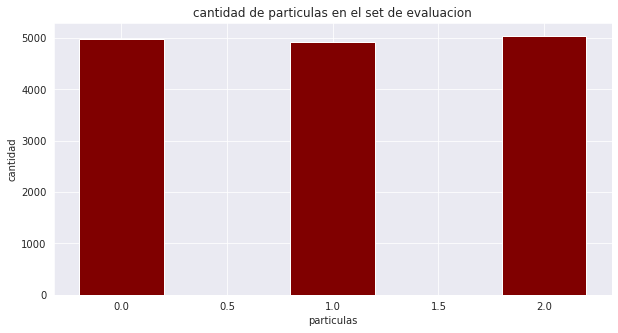

In [34]:

part = list(dfpred.groupby("label")["label"].count().keys())
cant = list(dfpred.groupby("label")["label"].count().values)

fig = plt.figure(figsize=(10, 5))

# creating the bar plot
plt.bar(part, cant, color='maroon', width=0.4)

plt.xlabel("particulas")
plt.ylabel("cantidad")
plt.title("cantidad de particulas en el set de evaluacion")
plt.savefig("./plots/dist_eval.png")

              precision    recall  f1-score   support

        muon       0.90      0.99      0.94      4984
    electron       0.94      0.94      0.94      4918
     piminus       0.96      0.87      0.91      5043

    accuracy                           0.93     14945
   macro avg       0.93      0.93      0.93     14945
weighted avg       0.93      0.93      0.93     14945



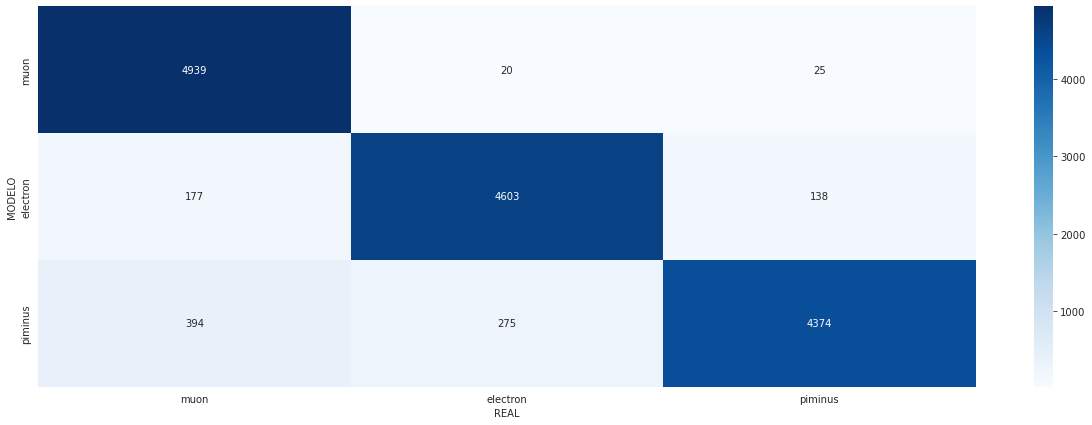

In [35]:
CM = confusion_matrix(dfpred['label'],dfpred['y_preds'])
print(classification_report(dfpred['label'],dfpred['y_preds'], target_names=['muon', 'electron', 'piminus']))
#print(CM)
dfmat = pd.DataFrame(CM, index=clases, columns=clases)
grafica = sb.heatmap(dfmat, cmap='Blues', annot=True, fmt='g')
grafica.set(xlabel='REAL', ylabel='MODELO')
plt.savefig('plots/confucion.png')
plt.show()

In [36]:
dfpred[dfpred['label']!=dfpred['y_preds']]

,index,run,subrun,evt,label,cycle,pdm,pde,pdp,y_preds,...,subevt,time,visE,visEinslc,vtx.x,vtx.y,vtx.z,zenith,euclidean,label_name
4,4,10855,7,824,1,0,0.227424,0.386103,0.386473,2,...,1,14005.0,0.251724,0.251724,104.648277,-154.495285,353.279968,0.200749,56.833366,electron
6,6,13165,7,393,1,0,0.559774,0.247380,0.192846,0,...,1,14005.0,0.148972,0.148972,-159.215424,153.235489,355.793152,0.888267,54.116898,electron
15,15,10785,3,194,1,0,0.002564,0.389295,0.608141,2,...,1,14005.0,0.151323,0.151323,148.378754,-55.755951,452.330841,-0.842817,68.369080,electron
20,20,13166,1,96,1,0,0.013152,0.224138,0.762709,2,...,1,14005.0,0.504989,0.503826,108.560684,85.171654,439.794800,-0.246902,75.539680,electron
23,23,11500,3,54,2,0,0.973055,0.001380,0.025565,0,...,1,14005.0,0.226051,0.195506,-60.622120,109.653854,173.485321,-0.231675,4.708123,piminus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14930,14930,11345,13,1073,2,0,0.498763,0.133726,0.367510,0,...,1,14005.0,0.169354,0.163801,-172.025543,-98.421501,281.943726,0.011896,37.384438,piminus
14936,14936,12020,19,136,1,0,0.007328,0.487966,0.504705,2,...,1,14005.0,2.386673,2.385705,98.735687,33.932804,459.337280,-0.325747,173.681000,electron
14937,14937,10801,14,1521,2,0,0.007130,0.569272,0.423598,1,...,1,14005.0,1.023155,0.984535,164.367157,105.634621,729.608032,0.408708,67.735558,piminus
14942,14942,11977,12,963,1,0,0.004143,0.496207,0.499650,2,...,1,14005.0,1.433564,1.400289,-64.838432,-102.854752,199.825806,-0.548869,56.200920,electron


/tmp/ipykernel_43515/65667216.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


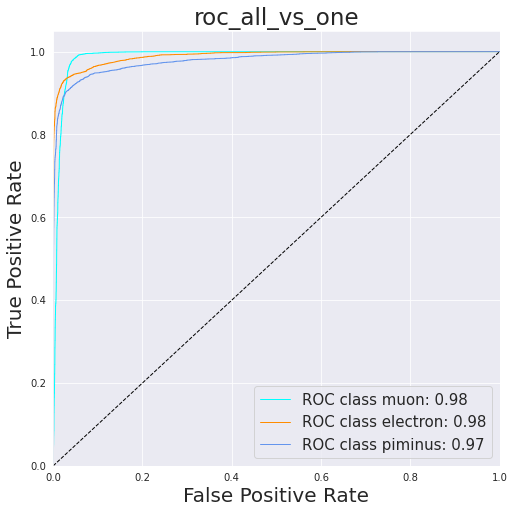

In [37]:
# Binarize the output
y_test = label_binarize(dfpred['label'], classes=[0,1,2])
n_classes = 3
y_score = dfpred[["pdm", "pde", "pdp"]].values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC class ' + clases[i] + ': ' + str(roc_auc[i])[
                                                                                        0:4])
    #ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('roc_all_vs_one', fontsize=23)
plt.legend(loc="lower right", prop={'size': 15})
plt.savefig("plots/roc_all_vs_one.jpg")
plt.show()

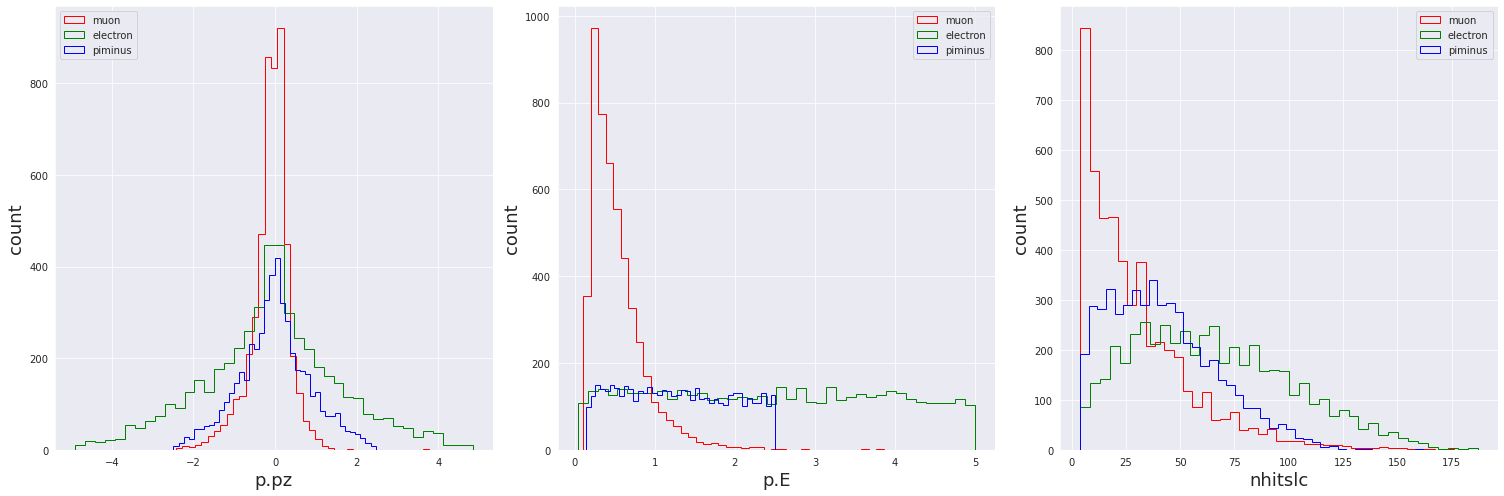

In [40]:

rcParams['figure.figsize'] = 21, 7
fig, axes = plt.subplots(nrows=1, ncols=3)
colors = ["red", "green", "blue", "yellow", "pink", "orange"]
for prop, ax in zip(['p.pz', 'p.E', 'nhitslc'], axes):
    for label, color in zip(['muon', 'electron', 'piminus'], ["red", "green", "blue"]):
        ax.hist((dfpred[dfpred['label_name'] == label])[prop], 40, histtype='step', stacked=True, fill=False,
                color=color, label=label)
        #ax.set_title(label, size=20)
        ax.set_ylabel('count', size=18)
        ax.set_xlabel(prop, size=18)
        ax.legend()
        ax.grid(True)

fig.tight_layout()
plt.savefig('plots/dist_prop_label.jpg')
plt.show()

/tmp/ipykernel_43515/1943760259.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_43515/1943760259.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_43515/1943760259.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')


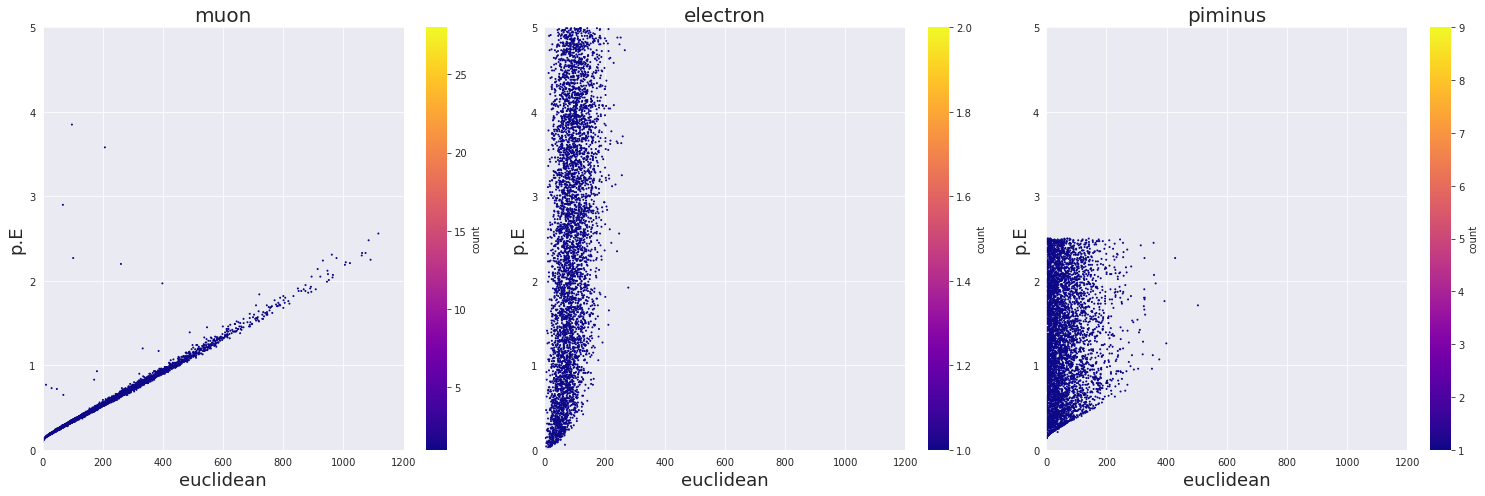

In [42]:

rcParams['figure.figsize'] = 21, 7
fig, axes = plt.subplots(nrows=1, ncols=3)
for label, prob, ax in zip(['muon', 'electron', 'piminus'], ['pdm', 'pde', 'pdp'], axes):
    df = (dfpred[dfpred['label_name'] == label])[['euclidean', 'p.E']]
    df = np.trunc(100 * df) / 100
    df = df.groupby(['euclidean', 'p.E']).size().reset_index(name='counts')
    colors = df['counts']
    p = ax.scatter(df['euclidean'], df['p.E'], s=1, vmin=1, vmax=colors.max(), c=colors, cmap='plasma')

    ax.set_title(label, size=20)
    ax.set_ylabel('p.E', size=18)
    ax.set_xlabel('euclidean', size=18)
    ax.set_xlim(0, 1200)
    ax.set_ylim(0, 5)
    ax.grid(True)
    cb = fig.colorbar(p, ax=ax, label='count')
    cb.outline.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig('plots/euclidean_vs_prop.jpg')
plt.show()

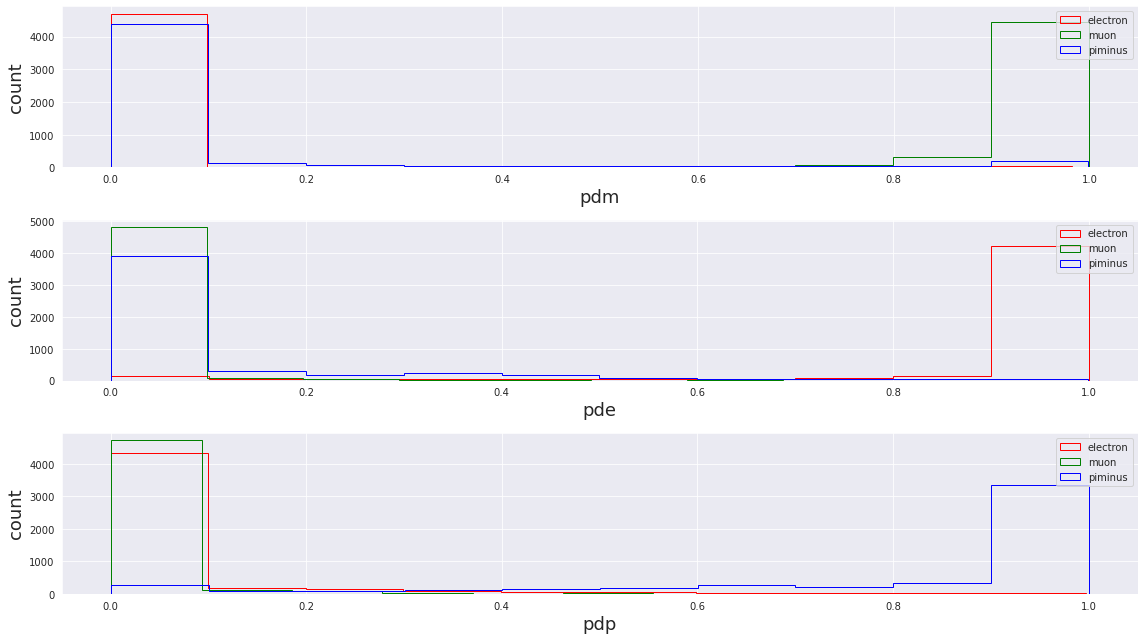

In [44]:
rcParams['figure.figsize'] = 16, 9
fig, axes = plt.subplots(nrows=3, ncols=1)
for prob, ax in zip(['pdm', 'pde', 'pdp'], axes):
    for label, color in zip(list(dfpred['label_name'].drop_duplicates()), ["red", "green", "blue"]):
        ax.hist((dfpred[dfpred['label_name'] == label])[prob], 10, histtype='step', stacked=True, fill=False,
                color=color, label=label)

        ax.legend()
        ax.set_xlabel(prob, size=18)
        ax.set_ylabel('count', size=18)
fig.tight_layout()
plt.savefig('plots/dist_score_label.jpg')
plt.show()

/tmp/ipykernel_43515/4161939480.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_43515/4161939480.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_43515/4161939480.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_43515/4161939480.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call 

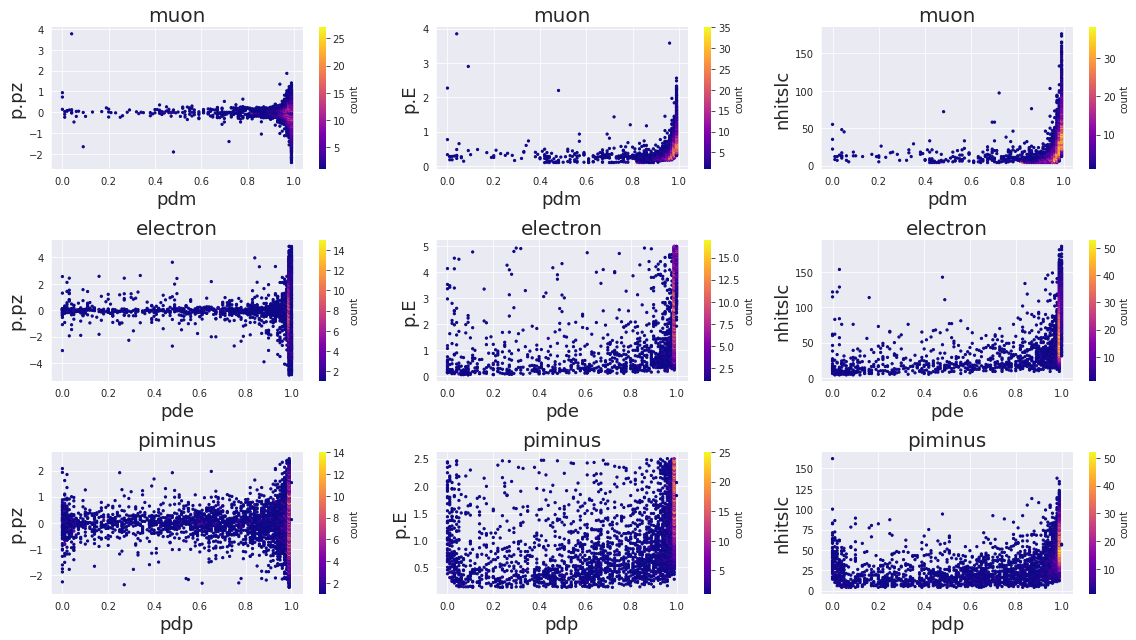

In [45]:
rcParams['figure.figsize'] = 16, 9
fig, axes = plt.subplots(nrows=3, ncols=3)
colors = ["red", "green", "blue", "yellow", "pink", "orange"]
for label, prob, filas in zip(['muon', 'electron', 'piminus'], ['pdm', 'pde', 'pdp'], axes):
    for prop, ax in zip(['p.pz', 'p.E', 'nhitslc'], filas):
        df = (dfpred[dfpred['label_name'] == label])[[prop, prob]]
        df = np.trunc(100 * df) / 100
        df = df.groupby([prob, prop]).size().reset_index(name='counts')
        colors = df['counts']
        p = ax.scatter(df[prob], df[prop], s=5, vmin=1, vmax=colors.max(), c=colors, cmap='plasma')

        ax.set_title(label, size=20)
        ax.set_ylabel(prop, size=18)
        ax.set_xlabel(prob, size=18)

        ax.grid(True)
        cb = fig.colorbar(p, ax=ax, label='count')
        cb.outline.set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig('plots/score_vs_prop.jpg')
plt.show()

In [ ]:
rcParams['figure.figsize'] = 16, 9
fig, axes = plt.subplots(nrows=3, ncols=3)
colors = ["red", "green", "blue", "yellow", "pink", "orange"]
for label, prob, filas in zip(['muon', 'electron', 'piminus'], ['pdm', 'pde', 'pdp'], axes):
    for prop, ax in zip(['p.pz', 'p.E', 'nhitslc'], filas):

        df = dfpred[dfpred['label_true'] == label]
        if (len(df) == 0): continue
        p_x, p_mean, p_rms = compute_profile(df[prob], df[prop], (5, 5))


        ax.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='r', color='g')
        #plt.errorbar(p_x, p_mean, p_rms,fmt='_', ecolor='r', c=colors[n], label=calificacion)
        ax.set_title(label, size=20)
        ax.set_ylabel(prop, size=18)
        ax.set_xlabel(prob, size=18)
        ax.legend()
        ax.grid(True)

fig.tight_layout()
plt.savefig('plots/profile_score_vs_prop.jpg')
plt.show()

In [ ]:
rcParams['figure.figsize'] = 21, 7
fig, axes = plt.subplots(nrows=1, ncols=3)
for label, prob, ax in zip(['muon', 'electron', 'piminus'], ['pdm', 'pde', 'pdp'], axes):
    df = (dfpred[dfpred['label_true'] == label])[[prob, 'euclidean']]
    df = np.trunc(100 * df) / 100
    df = df.groupby([prob, 'euclidean']).size().reset_index(name='counts')
    colors = df['counts']
    p = ax.scatter(df[prob], df['euclidean'], s=5, vmin=1, vmax=colors.max(), c=colors, cmap='plasma')

    ax.set_title(label, size=20)
    ax.set_ylabel('euclidean', size=18)
    ax.set_xlabel(prob, size=18)
    #ax.set_xlim(0, 1200)
    ax.set_ylim(0, 1200)
    ax.grid(True)

    cb = fig.colorbar(p, ax=ax, label='count')
    cb.outline.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig('plots/euclidean_vs_score.jpg')
plt.show()